In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

import random
import torch
import torch.nn.functional as F
from models import MLP
from copy import deepcopy
from scipy.special import expit
import seaborn as sns

import ternary
import math

import os
os.makedirs('plots', exist_ok=True)

save_plots = False

In [2]:
iris = datasets.load_iris()
np.random.seed(1)
shuffle = np.random.permutation(range(len(iris.target)))
train_size = 100

train_xs = iris.data[shuffle[:train_size]]
train_ys = iris.target[shuffle[:train_size]]

test_xs = iris.data[shuffle[train_size:]]
test_ys = iris.target[shuffle[train_size:]]

In [3]:
def NLL(zs, ys):
    return F.cross_entropy(zs, ys.to(dtype=torch.long))

def nn_models(n_models, **kwargs):
    models = []
    for seed in range(n_models):
        model = MLP(in_channels=4, hidden_channels=[100, 3], criterion=NLL, **kwargs)
        model.fit(train_xs, train_ys)
        models.append(model)
    return models

def BI_LSE(zs, axis=0, class_axis=-1):
    '''
    Bregman Information of random variable Z generated by G = LSE
    BI_G [ Z ] = E[ G( Z ) ] - G( E[ Z ] )
    We estimate with dataset zs = [Z_1, ..., Z_n] via
    1/n sum_i G( Z_i ) - G( 1/n sum_i Z_i )
    '''
    E_of_LSE = zs.logsumexp(axis=class_axis).mean(axis)
    LSE_of_E = zs.mean(axis).unsqueeze(axis).logsumexp(axis=class_axis).squeeze(axis)
    return E_of_LSE - LSE_of_E

def inner_product(a, b):
    ''' Batch wise inner product of last axis in a and b'''
    n_size, n_classes = a.shape
    return torch.bmm(a.view(n_size, 1, n_classes), b.view(n_size, n_classes, 1)).squeeze(-1).squeeze(-1)

def d_LSE(a, b):
    '''
    Bregman divergence generated by G = LSE
    d_G (a, b) = G(b) - G(a) - < grad G(a), b - a >
    We assume the classes are in the last axis.
    a: n x p
    b: n x p
    output: n x n
    '''
    G_of_a = a.logsumexp(axis=-1)
    G_of_b = b.logsumexp(axis=-1)
    grad_G_of_a = a.softmax(axis=-1)
    return G_of_b - G_of_a - inner_product(grad_G_of_a, b - a)

def alpha_CI_map(i=0):
    def alpha_CI_map_(p):
        logits = np.zeros((len(p),))
        # pivot on first class
        logits[1:] = np.log(p[1:]) - np.log(p[0])
        # construct CI values around i-th test instance
        preds = []
        for m in models:
            x = torch.from_numpy(test_xs[i:(i+1)]).to(dtype=torch.float32)
            preds += [m.model(x).detach()]
        preds = torch.stack(preds)
        E_of_logits = preds.mean(0)
        distance = d_LSE(E_of_logits, torch.tensor(logits).unsqueeze(0).to(dtype=torch.float32)).numpy()
        local_BI = BI_LSE(preds)
        alpha = local_BI.item() / distance
        return np.clip(alpha, 0, 0.2)
    return alpha_CI_map_

In [4]:
torch.manual_seed(1)
models = nn_models(20, patience=40, weight_decay=1e-1)

In [5]:
print([m.score(test_xs, test_ys) for m in models])

[0.94, 0.96, 0.96, 0.96, 0.96, 0.94, 0.96, 0.96, 0.96, 0.96, 0.98, 0.94, 0.94, 0.96, 0.94, 0.94, 0.96, 0.94, 0.98, 0.94]


In [6]:
preds = []
for m in models:
    x = torch.from_numpy(test_xs).to(dtype=torch.float32)
    preds += [m.model(x).detach()]
preds = torch.stack(preds)
local_BIs = BI_LSE(preds)
torch.sort(local_BIs)

torch.return_types.sort(
values=tensor([0.0022, 0.0024, 0.0024, 0.0025, 0.0025, 0.0025, 0.0026, 0.0031, 0.0031,
        0.0031, 0.0031, 0.0031, 0.0032, 0.0032, 0.0035, 0.0035, 0.0036, 0.0036,
        0.0037, 0.0037, 0.0037, 0.0039, 0.0039, 0.0039, 0.0039, 0.0045, 0.0047,
        0.0048, 0.0055, 0.0056, 0.0063, 0.0071, 0.0074, 0.0086, 0.0087, 0.0091,
        0.0092, 0.0093, 0.0096, 0.0101, 0.0102, 0.0103, 0.0106, 0.0109, 0.0109,
        0.0111, 0.0111, 0.0112, 0.0125, 0.0128]),
indices=tensor([45, 32, 14, 47, 46, 18, 43, 19, 36, 16, 38, 10, 35, 21, 26,  6,  4, 23,
        11, 48, 31, 41,  9,  3, 34, 29, 25,  1, 42, 37,  0, 30, 44, 27, 49, 13,
        12, 22, 33, 39, 20, 28,  5,  7, 15, 24, 17, 40,  8,  2]))

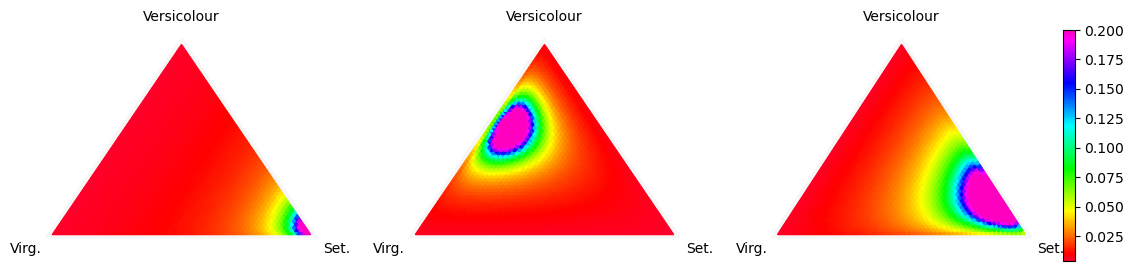

In [7]:
scale = 60
#pick a variety of instances (45 is tighest, 2 is widest)
instances = [0, 1, 2]
max_i = len(instances)

gridspec_kw={'width_ratios': [1, 1, 1.2]}
#plt.rcParams.update({'font.size': 14})
figure, axs = plt.subplots(1, max_i, gridspec_kw=gridspec_kw, figsize=(14, 3))

for i, instance in enumerate(instances):
    ax = axs[i]
    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax.heatmapf(alpha_CI_map(instance), boundary=False, colorbar=i==(max_i-1), cmap='gist_rainbow')
    tax.right_corner_label("Set.")#, offset=0.05)
    tax.top_corner_label("Versicolour")
    tax.left_corner_label("Virg.")#, offset=0.05)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()

if save_plots:
    plt.savefig('plots/CI_iris_mlp.png', bbox_inches='tight')
plt.show();

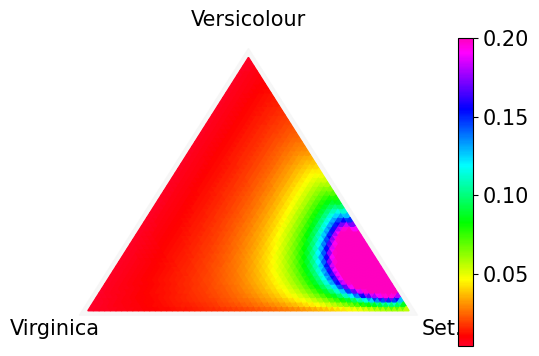

In [8]:
### Figure 4

scale = 60
plt.rcParams.update({'font.size': 15, 'figure.dpi': 100})
figure, ax = plt.subplots(1, 1, figsize=(6, 4))

tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
tax.heatmapf(alpha_CI_map(instance), boundary=False, cmap='gist_rainbow')
tax.right_corner_label("Set.")#, offset=0.05)
tax.top_corner_label("Versicolour")
tax.left_corner_label("Virginica")#, offset=0.05)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
if save_plots:
    plt.savefig('plots/CI_iris_single.png', bbox_inches='tight')
plt.show();